<a href="https://colab.research.google.com/github/tomafischer/ai_geeks/blob/main/deeplearning/Intro_to_Deep_Learning_30_minutes_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Deep Learning - a practical approach
This is a example for a deep learning intro in less than 30 minutes.

We will use a Artifical Neural Network (ANN) for a regression of MPG for cars

## 1) Data, Data, Data
We will use the Seaborn mpg.csv dataset to predict the mpg from car features


In [1]:
# the usual math and data packages
import numpy as np
import pandas as pd
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
# model evaluation, z-score
import scipy.stats as stats
# data prep
from sklearn.model_selection import train_test_split

# unit testing
import unittest

In [24]:
import seaborn as sns
cars_pd= sns.load_dataset('mpg')
#dropping na values
cars_pd = cars_pd.dropna()
print(f"Length for car data: {len(cars_pd)}\n ")
cars_pd.head()
# some plots to shwo the data


Length for car data: 392
 


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [25]:
# Statics on the numerical values
cars_pd.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


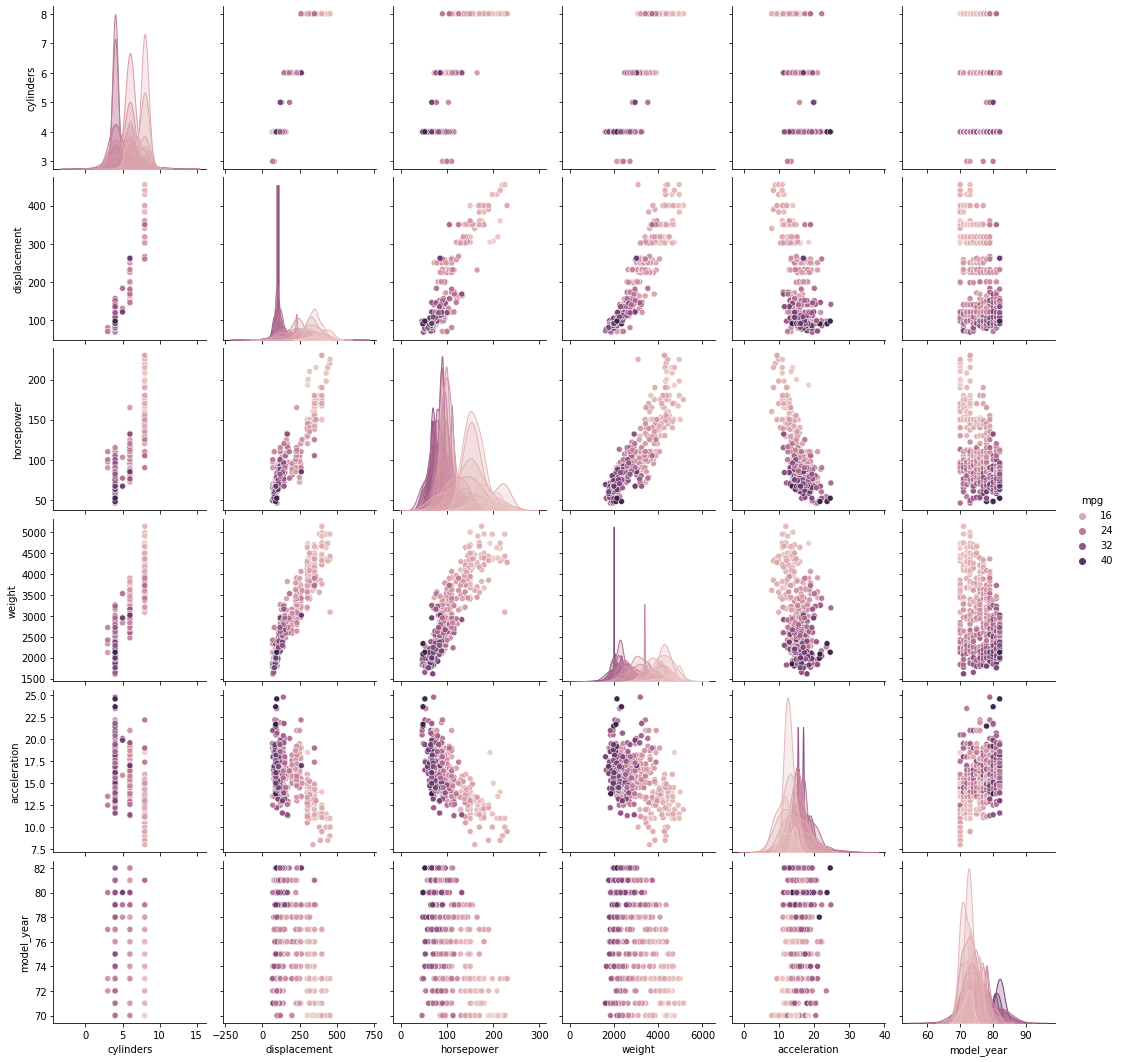

In [26]:
# Correlation Plots
sns.pairplot(cars_pd, hue='mpg')
plt.show()

In [27]:
#####
#.   Defining features
#####
feature_labels = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
pred_label =['mpg']

#####
#    Create Tensors
#####
cars_x = torch.tensor(cars_pd[feature_labels].values).float()
cars_y = torch.tensor(cars_pd[pred_label].values).float()
######
#.    Creating train and test set
######
train_x, test_x, train_y, test_y  = train_test_split(cars_x, cars_y, train_size=0.8)

In [28]:
cars_pd

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,europe,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger


In [29]:
print(f"Cars_x.shape:  {cars_x.shape}")
print(f"Cars_y.shape:  {cars_y.shape}")
print("Train data:")
print(f"train_x.shape: {train_x.shape}")
print(f"train_y.shape: {train_y.shape}")
print(f"Test data:")
print(f"test_x.shape:  {test_x.shape}")
print(f"test_y.shape:  {test_y.shape}")

Cars_x.shape:  torch.Size([392, 6])
Cars_y.shape:  torch.Size([392, 1])
Train data:
train_x.shape: torch.Size([313, 6])
train_y.shape: torch.Size([313, 1])
Test data:
test_x.shape:  torch.Size([79, 6])
test_y.shape:  torch.Size([79, 1])


In [39]:
# first few records
test_x[0:4,:]

tensor([[4.0000e+00, 1.4000e+02, 9.2000e+01, 2.5720e+03, 1.4900e+01, 7.6000e+01],
        [8.0000e+00, 3.5000e+02, 1.4500e+02, 4.4400e+03, 1.4000e+01, 7.5000e+01],
        [4.0000e+00, 9.0000e+01, 7.0000e+01, 1.9370e+03, 1.4200e+01, 7.6000e+01],
        [4.0000e+00, 6.8000e+01, 4.9000e+01, 1.8670e+03, 1.9500e+01, 7.3000e+01],
        [8.0000e+00, 3.6000e+02, 1.7000e+02, 4.6540e+03, 1.3000e+01, 7.3000e+01]])

In [40]:
test_y[0:4,:]

tensor([[25.],
        [15.],
        [29.],
        [29.]])

## 2) Creating Deep Learning Model

### Neural Network Layout and Math for one Neuron
<img src="https://github.com/tomafischer/ai_geeks/blob/main/images/neural_network.png?raw=true"
     alt="Neural Networks"
     style="float: left; margin-right: 10px;" width="600" height="270"/>
<img src="https://github.com/tomafischer/ai_geeks/blob/main/images/neural_networks_neuron_overview.jpeg?raw=true"
     alt="Neural Networks"
     style="float: left; margin-right: 10px;" width="600" height="270"/>


### What do we need:
- **Deep Learning Model** (see above)
- **Forward progagation**: Compute output based on input for predicting a dataset  
- **Loss Function**: Mesaure accuracy of model  => Root Square Mean RMS
- **Backwards propagation** (backprop): Adjust the weights based on loss/cost
- **Learning Rate**: Amount of adjustments during the backprop
- **Epochs**: Amount of iterations for the learning process. Each epoch uses the full dataset with full backprop 